# Simple time series model
### Using Naive Bayes for forecasting
This model takes advantage of one approach that is commonly known as binning (discretization or reducing the scale level of a random variable from numerical to categorical). An advantage of this technique is the reduction of noise - however, this comes at the cost of losing quite an amount of information.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import *
from sklearn.linear_model import LinearRegression
from simple_time_series import *

## Import and fix dataset

In [2]:
df = pd.read_csv('../../data/dataset.csv')
df.index = pd.to_datetime(df.pop('date'))
df = df.filter(['Canteen'])

Plot number of people vs time

Text(0.5, 1.0, 'Number of people at Telenor 2016-2019')

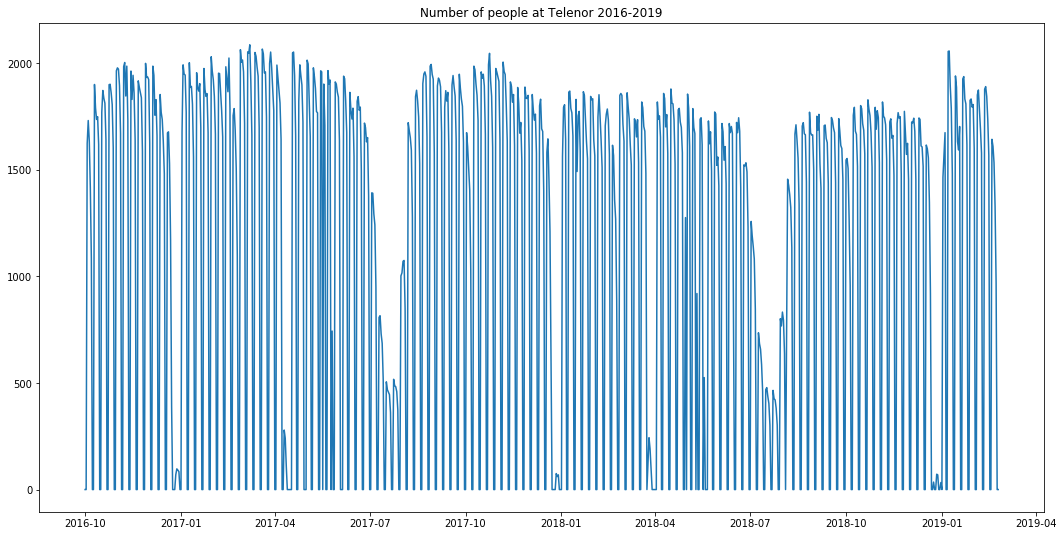

In [3]:
plt.figure(figsize=(18,9))
plt.plot(df)
plt.title('Number of people at Telenor 2016-2019')

## Test for stationarity

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

- constant mean
- constant variance
- an autocovariance that does not depend on time.

### Moving average
We can plot the moving average or moving variance and see if it varies with time. By moving average/variance I mean that at any instant 't', we’ll take the average/variance of the last year, i.e. last 12 months. This is more of a visual technique.

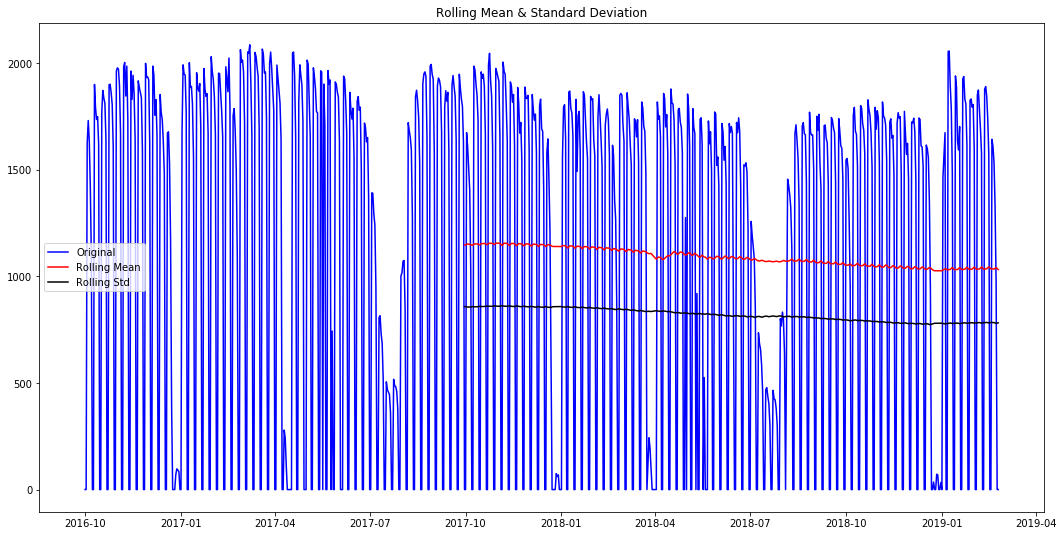

In [4]:
test_stationarity(df)

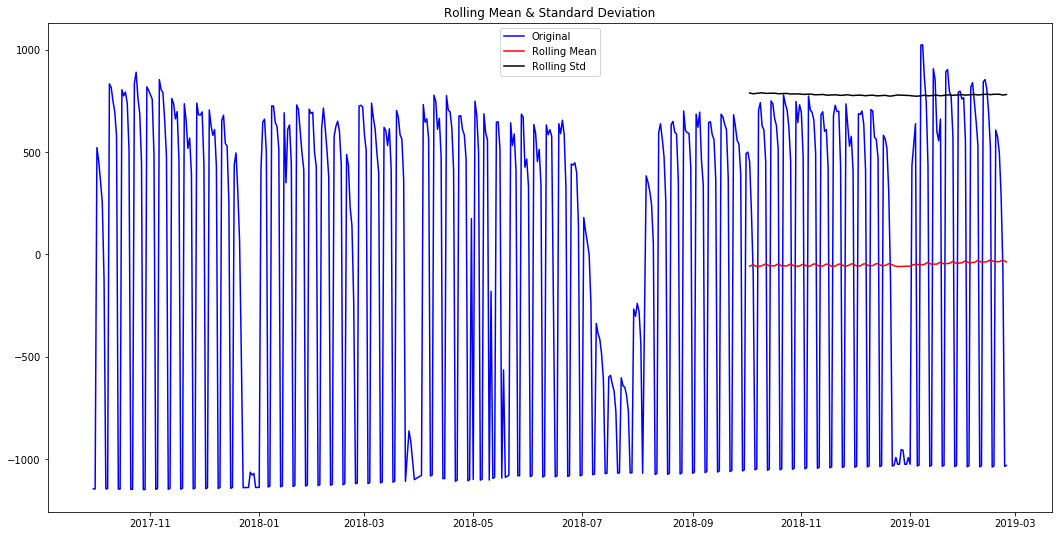

In [5]:
moving_avg_diff = df - df.rolling(365).mean()
moving_avg_diff.dropna(inplace=True)
test_stationarity(moving_avg_diff)

## Split dataset

In [6]:
test_period = 175 # 20% of total

train = df.iloc[:-test_period]
test = df.iloc[-test_period:]

## Preprocessing

In [ ]:
trend_removed = train.diff()

In [ ]:
plt.figure(figsize=(18,9))
plt.plot(trend_removed)

In [ ]:
df2.std()

In [ ]:
from sklearn import preprocessing

x = df2.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized = pd.DataFrame(x_scaled)

In [ ]:
diffs = normalized.diff()

## Binning the data
To bin the data,  K∈ℤ+  intervals on ℝ are being assigned. Now, each continuous observation xt is replaced by an indicator xt=k, k∈{1;...;K} where k is the interval that xt falls in. The number of intervals was chosen arbitrarily.

In [7]:
bins = [-1, 1, 200, 500, 1000, 1500, 1700, 1800, 1900, 10000] # Desired bins for people in canteen
# bins = [-1, 1, 100, 300, 500, 700, 1000, 1200, 1500, 1700, 1800, 1900, 10000]

The data are binned and the mean of realizations xt in each interval is saved in a dictionary in order to map the interval category back to actual realizations (bin_means).

In [8]:
binned_series, bin_means = bin_data(train, bins)
binned_test_series, bin_test_means = bin_data(test, bins)

In [9]:
binned_series.head()

date
2016-10-01    1
2016-10-02    1
2016-10-03    6
2016-10-04    7
2016-10-05    6
dtype: int64

In [10]:
bin_means

{1: Canteen    0.0
 dtype: float64, 2: Canteen    94.7
 dtype: float64, 3: Canteen    401.304348
 dtype: float64, 4: Canteen    725.75
 dtype: float64, 5: Canteen    1299.860465
 dtype: float64, 6: Canteen    1621.409091
 dtype: float64, 7: Canteen    1750.82716
 dtype: float64, 8: Canteen    1851.655556
 dtype: float64, 9: Canteen    1966.353535
 dtype: float64}

To forecast future realizations, the classic approach of using  S∈ℤ+  lagged realizations of  xt  will be applied. The amount of lags I chose was  365, assuming that there is no longer auto-dependency of the process beyond a horizon of one year.

In [11]:
train_x, train_y = get_lagged_list(binned_series, 92)

In [12]:
train_x.head()

,1,2,3,4,5,6,7,8,9,10,...,82,83,84,85,86,87,88,89,90,91
date,,,,,,,,,,,,,,,,,,,,,
2016-12-31,2.0,2.0,2.0,2.0,1.0,1.0,1.0,3.0,5.0,6.0,...,8.0,1.0,1.0,5.0,5.0,6.0,7.0,6.0,1.0,1.0
2017-01-01,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,3.0,5.0,...,7.0,8.0,1.0,1.0,5.0,5.0,6.0,7.0,6.0,1.0
2017-01-02,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,3.0,...,7.0,7.0,8.0,1.0,1.0,5.0,5.0,6.0,7.0,6.0
2017-01-03,6.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,...,7.0,7.0,7.0,8.0,1.0,1.0,5.0,5.0,6.0,7.0
2017-01-04,9.0,6.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,...,6.0,7.0,7.0,7.0,8.0,1.0,1.0,5.0,5.0,6.0


In [13]:
train_y.head()

date
2016-12-31    1
2017-01-01    1
2017-01-02    6
2017-01-03    9
2017-01-04    9
Name: 0, dtype: int64

## Predictive Model

In [14]:
model = create_model(train_x, train_y)

To calculate the 'class'-means from before, I wrote a quick function that takes the predicted class as an input and returns the corresponding means.

In [15]:
resulting_prediction = find_training_prediction(train_x, train_y, model, bin_means)

### Plot training prediction

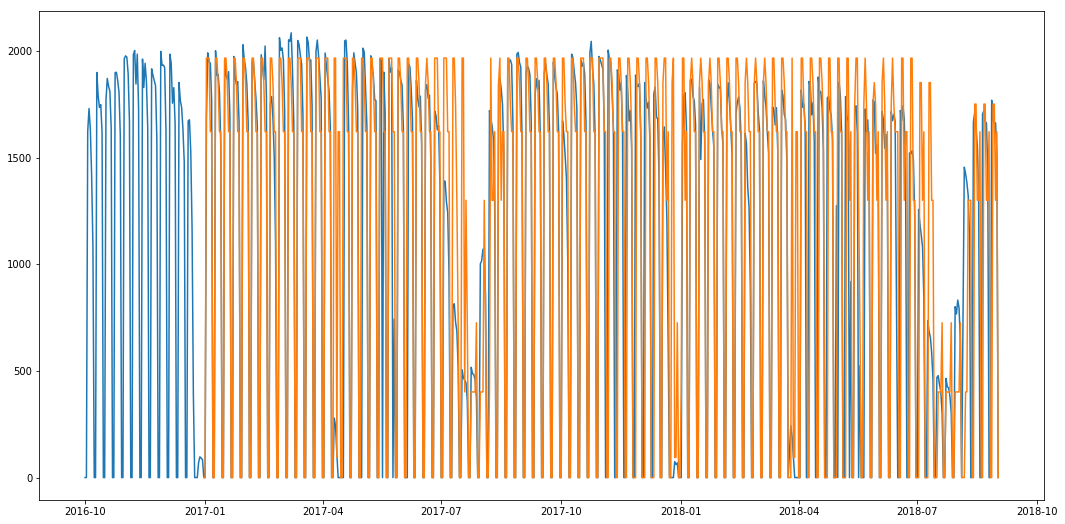

In [16]:
plt.figure(figsize = (18,9))
plt.plot(train)
plt.plot(resulting_prediction)

### Finding predictions for test set (out of samle forecast)

Out-of-sample forecasts need to be calculated iteratively since lagged values are required.

In [17]:
predictions, pred_class = find_prediction_forecast(test, train_x, train_y, model, bin_means)

# Results

### Plotting prediction of test set

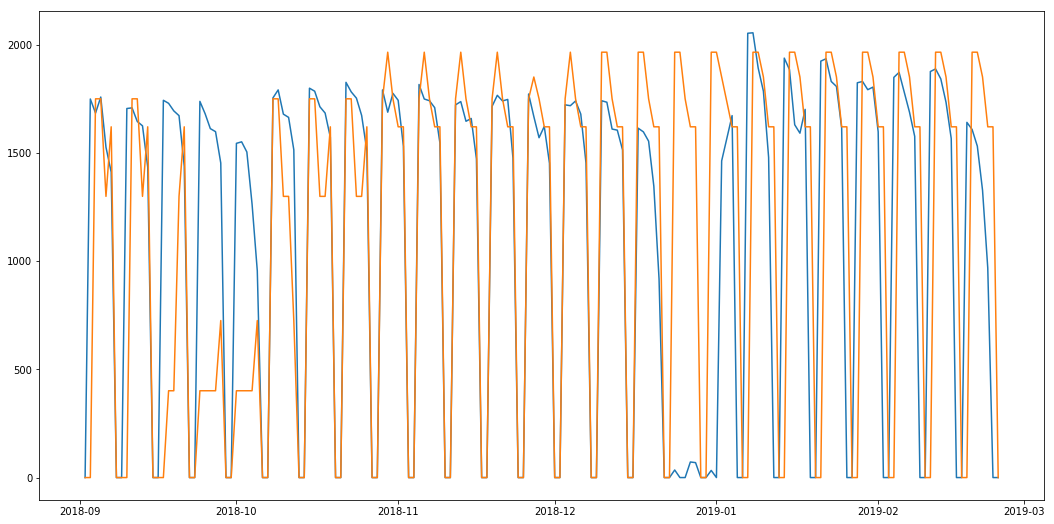

In [18]:
plt.figure(figsize = (18,9))
plt.plot(test)
plt.plot(predictions)

### Plotting both train and test prediction

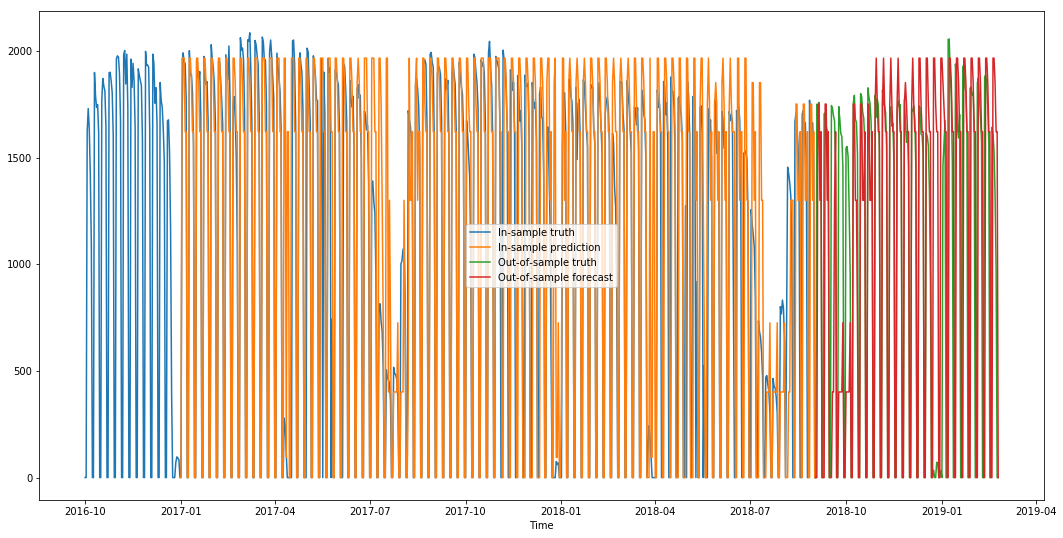

In [19]:
plt.figure(figsize = (18,9))
plt.plot(train)
plt.plot(resulting_prediction)

plt.plot(test)
plt.plot(predictions)
plt.xlabel("Time")
plt.legend(["In-sample truth", "In-sample prediction", "Out-of-sample truth", "Out-of-sample forecast"])

## RMSE and accuracy

### Testing accuracy

In [20]:
accuracy = test_accuracy(pred_class, binned_test_series)
print('The accuracy is ' + str(accuracy) + ' %')

The accuracy is 44.0 %


### RMSE

RMSE for test data and prediction:

In [21]:
find_RMSE(test, predictions)

747.7678269235709

RMSE for training data and prediction:

In [22]:
find_RMSE(train, resulting_prediction)

533.2519667451357